/home/user/anaconda3/envs/crawling/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Main] Reading CSV headers from /home/user/Desktop/ai_courses_global.csv...
[Main] Detected columns: ['course', 'professor', 'code', 'link', 'year', 'description']
[LLM] Loading model and tokenizer...


Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


[LLM] Model loaded to cpu
[Schema] Inferring schema relations for columns: ['course', 'professor', 'code', 'link', 'year', 'description']
[Schema] Prompt sent to LLM:

    You are an expert schema designer.
    Given these field names:
    - course
- professor
- code
- link
- year
- description

    Identify all meaningful relationships between any two of these fields.
    Output ONLY an array of [head, relation, tail] triples,
    as in this example:
    [["Entity A", "related to", "Entity B"],
    ["Entity C", "measured in", "Unit"],
    ["Event", "occurred on", "Date"]]

    Do not add any description or extra text—only the array.
    


/home/user/anaconda3/envs/crawling/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


----- RAW SCHEMA OUTPUT -----

    [["course", "has_code", "code"],
    ["course", "taught_by", "professor"],
    ["course", "offered_in", "year"],
    ["course", "has_description", "description"]]


-----------------------------
[Schema] Parsed 4 relations.
[Main] Schema relation: course --has_code--> code
[Main] Schema relation: course --taught_by--> professor
[Main] Schema relation: course --offered_in--> year
[Main] Schema relation: course --has_description--> description
[Graph] Building schema-only graph...
[Graph] Schema graph has 5 nodes and 4 edges.


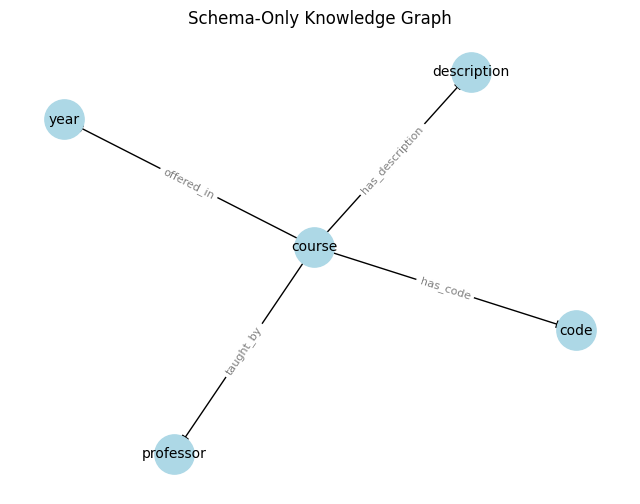

[Populate] Reading CSV from /home/user/Desktop/ai_courses_global.csv...
[Populate] Loaded 186 rows × 6 columns.
[Populate] Row 0
  - (Neural Networks for Machine Learning, has_code, Lecture-Slides / CSC321-tijmen)
  - (Neural Networks for Machine Learning, taught_by, Geoffrey Hinton, University of Toronto)
  - (Neural Networks for Machine Learning, offered_in, 2012/2014)
  - (Neural Networks for Machine Learning, has_description, "Neural Networks for Machine Learning" is a comprehensive course taught by Geoffrey Hinton, a pioneer in artificial intelligence and a professor at the University of Toronto. Originally offered on Coursera between 2012 and 2014, the course delves into the fundamentals of artificial neural networks and their applications in machine learning tasks such as speech and object recognition, image segmentation, language modeling, and human motion analysis. It emphasizes both foundational algorithms and practical techniques essential for effectively training deep learn

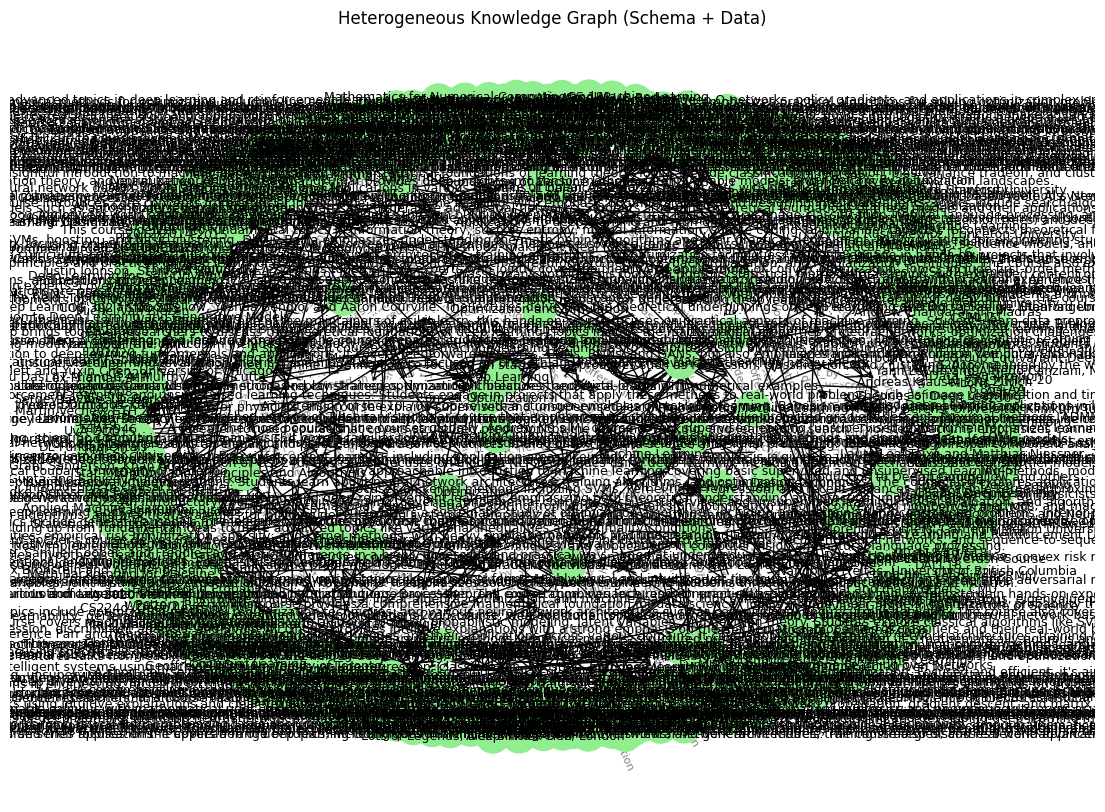

[Subgraph] 5 nodes, 4 edges:
['2017', 'DL-book slides', 'Deep Learning Book companion videos', 'Ian Goodfellow and others', 'This video series serves as a companion to the seminal textbook "Deep Learning" by Ian Goodfellow, Yoshua Bengio, and Aaron Courville. The lectures delve into the theoretical underpinnings of deep learning, covering topics like linear algebra, probability theory, optimization, and machine learning fundamentals. It\'s an invaluable resource for readers of the book who wish to reinforce their understanding through visual and auditory means.']


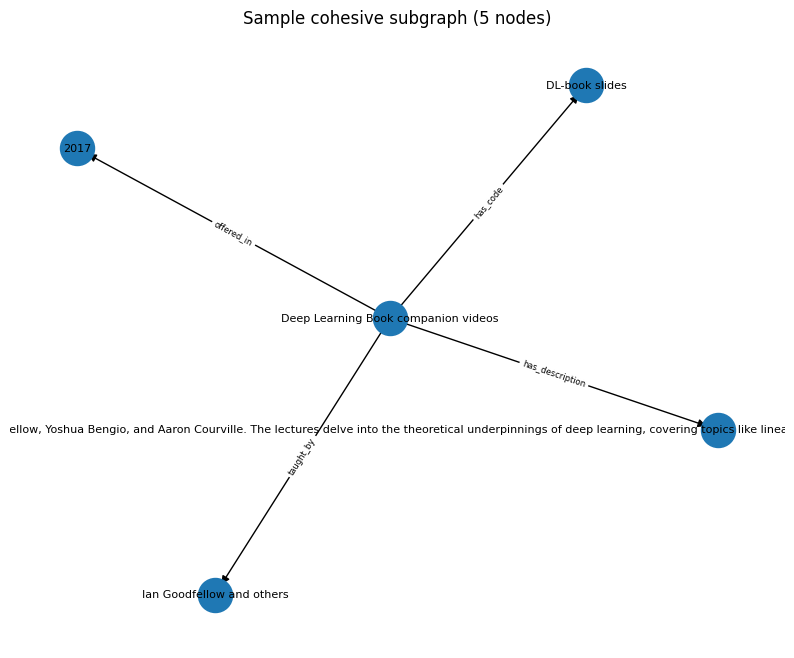

In [1]:
import os
import re
import json
import pandas as pd
import torch
import random
from itertools import islice
from transformers import AutoModelForCausalLM, AutoTokenizer
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

# suppress tqdm warnings
os.environ["TRANSFORMERS_NO_TQDM"] = "true"


def initialize_llm(
    model_name: str = "microsoft/phi-3-mini-4k-instruct"
) -> Tuple[AutoModelForCausalLM, AutoTokenizer, torch.device]:
    """
    Load the pretrained causal LLM and tokenizer on CPU.
    """
    print("[LLM] Loading model and tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="cpu"
    )
    device = torch.device("cpu")
    print(f"[LLM] Model loaded to {device}")
    return model, tokenizer, device


def infer_schema_relations(
    model: AutoModelForCausalLM,
    tokenizer: AutoTokenizer,
    device: torch.device,
    columns: List[str],
    max_new_tokens: int = 60,
    temperature: float = 0.0
) -> List[Tuple[str, str, str]]:
    """
    Ask the LLM once to infer general relations among the column titles.
    Uses greedy decoding for speed, because the task is structured and predictable.
    Returns a list of (head_col, relation, tail_col) tuples.
    """
    print(f"[Schema] Inferring schema relations for columns: {columns}")
    bullet_list = "\n".join(f"- {col}" for col in columns) # bullet list of the attributes==entities for the prompt
    
    # curated prompt for triplet extraction, that predicts heterogeneous links
    prompt = f"""
    You are an expert schema designer.
    Given these field names:
    {bullet_list}

    Identify all meaningful relationships between any two of these fields.
    Output ONLY an array of [head, relation, tail] triples,
    as in this example:
    [["Entity A", "related to", "Entity B"],
    ["Entity C", "measured in", "Unit"],
    ["Event", "occurred on", "Date"]]

    Do not add any description or extra text—only the array.
    """
    print("[Schema] Prompt sent to LLM:")
    print(prompt)

    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False, # greedy decoding
            temperature=temperature, # randomness: lower more deterministic, higher more random
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id
        )

    raw = tokenizer.decode(
        out[0, inputs["input_ids"].shape[1]:], skip_special_tokens=True
    ) # agent's raw schema prediction
    print("----- RAW SCHEMA OUTPUT -----")
    print(raw)
    print("-----------------------------")

    # extract json-like array
    json_str = None
    m = re.search(r"```json\s*(\[[\s\S]*?\])\s*```", raw)
    if m:
        json_str = m.group(1)
    else: 
        start = raw.find("[")
        end = raw.rfind("]")
        if start != -1 and end != -1:
            json_str = raw[start:end+1]

    if not json_str:
        raise RuntimeError(f"Could not locate a JSON array in LLM output:\n{raw}")

    try:
        arr = json.loads(json_str)
    except json.JSONDecodeError as e:
        raise RuntimeError(f"JSON parse error: {e}\nOffending string:\n{json_str}")

    schema = []
    for triple in arr:
        if isinstance(triple, list) and len(triple) == 3:
            schema.append((triple[0], triple[1], triple[2]))
    print(f"[Schema] Parsed {len(schema)} relations.")
    return schema

def populate_schema_from_csv(
    schema: List[Tuple[str, str, str]],
    csv_path: str = "/home/user/Desktop/ai_courses_global.csv"
) -> List[Tuple[str, str, str]]:
    """
    Given a schema over column names, read the CSV at `csv_path`,
    and return all (head_value, relation, tail_value) triples
    for rows where both fields are non-null.
    """
    print(f"[Populate] Reading CSV from {csv_path}...")
    df = pd.read_csv(csv_path)
    print(f"[Populate] Loaded {df.shape[0]} rows × {df.shape[1]} columns.")

    triplets: List[Tuple[str, str, str]] = []
    for idx, row in df.iterrows():
        print(f"[Populate] Row {idx}")
        for head_col, rel, tail_col in schema:
            hval = row.get(head_col)
            tval = row.get(tail_col)
            if pd.notna(hval) and pd.notna(tval):
                h = str(hval).strip()
                t = str(tval).strip()
                triplets.append((h, rel, t))
                print(f"  - ({h}, {rel}, {t})")
    print(f"[Populate] Generated {len(triplets)} triplets total.")
    return triplets

def build_and_visualize_graph(
    triplets: List[Tuple[str, str, str]],
    column_types: Dict[str, str]
) -> nx.MultiDiGraph:
    """
    Build a heterogeneous graph from the triplets, assigning each node
    a node_type based on which column it came from, then display it.
    """
    print("[Graph] Building heterogeneous graph...")
    G = nx.MultiDiGraph()
    for head, rel, tail in triplets:
        ht = column_types.get(head, "entity")
        tt = column_types.get(tail, "entity")
        if not G.has_node(head):
            G.add_node(head, node_type=ht)
        if not G.has_node(tail):
            G.add_node(tail, node_type=tt)
        G.add_edge(head, tail, key=rel, relation=rel)
    print(f"[Graph] Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    print("[Graph] Visualizing graph...")
    pos = nx.spring_layout(G, seed=42, k=1.0)
    plt.figure(figsize=(14, 10))
    node_colors = [
        "skyblue" if data["node_type"] == "course" else "lightgreen"
        for _, data in G.nodes(data=True)
    ]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=600)
    nx.draw_networkx_labels(G, pos, font_size=9)
    for u, v, _, data in G.edges(keys=True, data=True):
        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            arrowstyle="-|>",
            arrowsize=10,
            connectionstyle="arc3,rad=0.1"
        )
        nx.draw_networkx_edge_labels(
            G, pos,
            edge_labels={(u, v): data["relation"]},
            font_color="gray",
            font_size=8,
            label_pos=0.5
        )
    plt.axis("off")
    plt.title("Heterogeneous Knowledge Graph (Schema + Data)")
    plt.show()

    return G 

def build_and_visualize_schema_graph(
    schema: List[Tuple[str, str, str]]
) -> None:
    """
    Build and display a graph of just the schema: column-to-column relations.
    """
    print("[Graph] Building schema-only graph...")
    G = nx.DiGraph()
    for head_col, rel, tail_col in schema:
        G.add_node(head_col, node_type="field")
        G.add_node(tail_col, node_type="field")
        G.add_edge(head_col, tail_col, relation=rel)
    print(f"[Graph] Schema graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=800)
    nx.draw_networkx_labels(G, pos, font_size=10)
    edge_labels = {(u, v): data["relation"] for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowstyle="-|>", arrowsize=12)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="gray", font_size=8)
    plt.axis("off")
    plt.title("Schema-Only Knowledge Graph")
    plt.show()

def visualize_sample_subgraph(G: nx.MultiDiGraph,
                              n_nodes: int = 5,
                              seed: int = 42) -> None:
    if G.number_of_nodes() == 0:
        print("[Subgraph] Empty graph.")
        return

    rnd = random.Random(seed)
    start = rnd.choice(list(G.nodes))
    bfs_nodes = list(islice(
        nx.bfs_tree(G.to_undirected(), start), n_nodes))

    H = G.subgraph(bfs_nodes).copy()

    print(f"[Subgraph] {len(H)} nodes, {H.number_of_edges()} edges:")
    print(sorted(H.nodes))

    pos = nx.spring_layout(H, seed=seed)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(H, pos, node_size=600)
    nx.draw_networkx_edges(H, pos, arrowstyle="-|>", arrowsize=12)
    nx.draw_networkx_labels(H, pos, font_size=8)

    # Optional: show one edge-label per (u,v) pair
    edge_labels = {(u, v): d["relation"]
                   for u, v, _, d in H.edges(keys=True, data=True)}
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels,
                                 font_size=6)

    plt.title(f"Sample cohesive subgraph ({len(H)} nodes)")
    plt.axis("off")
    plt.show()

# def main() -> None:
csv_path = "/home/user/Desktop/ai_courses_global.csv"
print(f"[Main] Reading CSV headers from {csv_path}...")
df = pd.read_csv(csv_path, nrows=0)  # only read header
columns = list(df.columns)
print(f"[Main] Detected columns: {columns}")

model, tokenizer, device = initialize_llm()
schema = infer_schema_relations(model, tokenizer, device, columns)
for h, r, t in schema:
    print(f"[Main] Schema relation: {h} --{r}--> {t}")

build_and_visualize_schema_graph(schema)

instance_triplets = populate_schema_from_csv(schema, csv_path)

column_types: Dict[str, str] = {}
for col in df.columns:
    for val in df[col].dropna().astype(str):
        column_types[val.strip()] = col.lower()

G = build_and_visualize_graph(instance_triplets, column_types)
visualize_sample_subgraph(G)


# if __name__ == "__main__":
#     main()


In [ ]:
# independent components
n_comp = nx.number_weakly_connected_components(G)
sizes  = [len(c) for c in nx.weakly_connected_components(G)]
print(f"[Diag] {n_comp} weakly-connected components "
      f"(largest = {max(sizes)} nodes)")

In [ ]:
# convert to undirected to find components and bridging nodes
undirected = G.to_undirected()

# find connected components
components = list(nx.connected_components(undirected))
print(f"Graph has {len(components)} connected components.")

# count how many components each node appears in (based on neighbors)
node_to_components = {}
for i, comp in enumerate(components):
    for node in comp:
        node_to_components[node] = i

# find nodes that connect multiple nodes i.e. appear multiple times in dataset
bridge_candidates = [node for node in G.nodes if G.degree[node] > 1]

# sort by degree
sorted_bridges = sorted(bridge_candidates, key=lambda n: G.degree[n], reverse=True)

# print the top bridge nodes
print("\nTop bridge-like nodes (shared across courses):")
for node in sorted_bridges[:10]:  # adjust number as needed
    print(f"- {node} (degree: {G.degree[node]}, type: {G.nodes[node].get('node_type', 'unknown')})")


Graph has 8 connected components.

Top bridge-like nodes (shared across courses):
- Deep Learning (degree: 56, type: entity)
- Machine Learning (degree: 52, type: entity)
- Introduction to Machine Learning (degree: 31, type: entity)
- Introduction to Deep Learning (degree: 21, type: entity)
- Convex Optimization (degree: 18, type: entity)
- 2018 (degree: 13, type: entity)
- Statistical Machine Learning (degree: 13, type: entity)
- 2019 (degree: 12, type: entity)
- 2015 (degree: 11, type: entity)
- Neural Networks (degree: 11, type: entity)
